[https://github.com/jayroxis/PINNs](https://)

# Problem statement

$$ i \psi_t + 0.5 \psi_{xx} + |\psi|^2 \psi=0, x \in [x_0, x_1], t \in [0, t_{max}]$$
$$ \psi(x, 0) = \psi_0(x)$$
$$ \psi(x_0, t) = \psi(x_1, t)$$
$$ \psi_x(x_0, t) = \psi_x(x_1, t)$$

# Libraries and Dependencies

In [ ]:
!pip install pyDOE

In [2]:
import sys
sys.path.insert(0, '../Utilities/')

import torch
from collections import OrderedDict

from pyDOE import lhs
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from scipy.interpolate import griddata
#from plotting import newfig, savefig
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
import time

#np.random.seed(1234)

In [ ]:
# CUDA support 
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
device

device(type='cuda')

# Physics-informed Neural Networks

In [ ]:
# the deep neural network
class DNN(torch.nn.Module):
    def __init__(self, layers):
        super(DNN, self).__init__()
        
        # parameters
        self.depth = len(layers) - 1
        
        # set up layer order dict
        self.activation = torch.nn.Tanh
        
        layer_list = list()
        for i in range(self.depth - 1): 
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1]))
            )
            layer_list.append(('activation_%d' % i, self.activation()))
            
        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1]))
        )
        layerDict = OrderedDict(layer_list)
        
        # deploy layers
        self.layers = torch.nn.Sequential(layerDict)
        
    def forward(self, x):
        out = self.layers(x)
        return out

In [ ]:
# enable loss weighting according to error
#weights = torch.tensor(dh_x[:, None], requires_grad=False).float().to(device)

In [ ]:
# the physics-guided neural network
class PhysicsInformedNN():
    def __init__(self, x0, u0, v0, tb, X_f, layers, lb, ub, a=0.):
    #def __init__(self, X_u, u, X_f, layers, lb, ub, nu, a=0.):
        
        # boundary conditions
        self.lb = torch.tensor(lb).float().to(device)
        self.ub = torch.tensor(ub).float().to(device)
        
        # data
        X0 = np.concatenate((x0, 0*x0), 1)
        X_lb = np.concatenate((0*tb + lb[0], tb), 1) # (lb[0], tb)
        X_ub = np.concatenate((0*tb + ub[0], tb), 1) # (ub[0], tb)
        self.x0 = torch.tensor(X0[:, 0:1], requires_grad=True).float().to(device)
        self.t0 = torch.tensor(X0[:, 1:2], requires_grad=True).float().to(device)
        self.x_lb = torch.tensor(X_lb[:,0:1], requires_grad=True).float().to(device)
        self.t_lb = torch.tensor(X_lb[:,1:2], requires_grad=True).float().to(device)

        self.x_ub = torch.tensor(X_ub[:,0:1], requires_grad=True).float().to(device)
        self.t_ub = torch.tensor(X_ub[:,1:2], requires_grad=True).float().to(device)

        self.x_f = torch.tensor(X_f[:, 0:1], requires_grad=True).float().to(device)
        self.t_f = torch.tensor(X_f[:, 1:2], requires_grad=True).float().to(device)
        self.u0 = torch.tensor(u0).float().to(device)
        self.v0 = torch.tensor(v0).float().to(device)
        
        self.layers = layers
        self.a = a
        
        # deep neural networks
        self.dnn = DNN(layers).to(device)
        
        # optimizers: using the same settings
        self.optimizer_adam = torch.optim.Adam(self.dnn.parameters(), lr=1e-4)
        self.optimizer = torch.optim.LBFGS(
            self.dnn.parameters(), 
            lr=1.0, 
            max_iter=50000, 
            max_eval=50000, 
            history_size=50,
            tolerance_grad=1e-7, 
            tolerance_change=1.0 * np.finfo(float).eps,
            line_search_fn="strong_wolfe"       # can be "strong_wolfe"
        )

        self.iter = 0
        self.losses = []
        
    def net_uv(self, x, t):  
        uv = self.dnn(torch.cat([x, t], dim=1))
        u = uv[:,0:1]
        v = uv[:,1:2]
        u_x = torch.autograd.grad(
            u, x, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True)[0]
        v_x = torch.autograd.grad(
            v, x, 
            grad_outputs=torch.ones_like(v),
            retain_graph=True,
            create_graph=True)[0]
        return u, v, u_x, v_x
    
    def net_f(self, x, t):
        """ The pytorch autograd version of calculating residual """
        u, v, u_x, v_x = self.net_uv(x, t)
        
        u_t = torch.autograd.grad(
            u, t, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True)[0]
        
        v_t = torch.autograd.grad(
            v, t, 
            grad_outputs=torch.ones_like(v),
            retain_graph=True,
            create_graph=True)[0]

        u_xx = torch.autograd.grad(
            u_x, x, 
            grad_outputs=torch.ones_like(u_x),
            retain_graph=True,
            create_graph=True)[0]

        v_xx = torch.autograd.grad(
            v_x, x, 
            grad_outputs=torch.ones_like(v_x),
            retain_graph=True,
            create_graph=True)[0]
        
        f_u = u_t + 0.5*v_xx + (u**2 + v**2) * (v + self.a * u_x)
        f_v = v_t - 0.5*u_xx - (u**2 + v**2) * (u - self.a * v_x)  
        return f_u, f_v
    
    def loss_func(self):
        self.optimizer.zero_grad()
        
        u0_pred, v0_pred, _, _ = self.net_uv(self.x0, self.t0)
        f_u_pred, f_v_pred  = self.net_f(self.x_f, self.t_f)
        # enable loss weighting according to error 
        #f_u_pred = torch.mul(f_u_pred, weights) # !
        #f_v_pred = torch.mul(f_v_pred, weights) # !
        u_lb, v_lb, u_x_lb, v_x_lb = self.net_uv(self.x_lb, self.t_lb)
        u_ub, v_ub, u_x_ub, v_x_ub = self.net_uv(self.x_ub, self.t_ub)
        
        loss_ic = torch.mean((self.u0 - u0_pred) ** 2) + torch.mean((self.v0 - v0_pred) ** 2)
        loss_bc = torch.mean((u_lb - u_ub)**2) + torch.mean((v_lb - v_ub)**2) + \
                  torch.mean((u_x_lb - u_x_ub)**2) + torch.mean((v_x_lb - v_x_ub)**2)
        loss_f = torch.mean(f_u_pred ** 2) + torch.mean(f_v_pred ** 2)
        
        loss = loss_ic + loss_bc + loss_f
        
        loss.backward()
        self.iter += 1
        if self.iter % 500 == 0:
            print(
                'Iter %d, Loss: %.5e, Loss_u: %.5e, Loss_f: %.5e' % (self.iter, loss.item(), loss_ic.item()+loss_bc.item(), loss_f.item())
            )
        self.losses.append(loss.item())
        return loss
    
    def train(self):
        self.dnn.train()
                
        # Backward and optimize
        for i in range(15000):
          self.optimizer_adam.step(self.loss_func)
        self.optimizer.step(self.loss_func)

            
    def predict(self, X):
        x = torch.tensor(X[:, 0:1], requires_grad=True).float().to(device)
        t = torch.tensor(X[:, 1:2], requires_grad=True).float().to(device)

        self.dnn.eval()
        u, v, _, _ = self.net_uv(x, t)
        #f = self.net_f(x, t)
        u = u.detach().cpu().numpy()
        v = v.detach().cpu().numpy()
        return u, v

# Data

In [3]:
from google.colab import files

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [16]:
x = np.loadtxt('/content/gdrive/MyDrive/PINNs/x_0.1.txt')
u = np.loadtxt('/content/gdrive/MyDrive/PINNs/u_0.1.txt')
v = np.loadtxt('/content/gdrive/MyDrive/PINNs/v_0.1.txt')

* $t_{max} = 1.57$

In [5]:
hlf = u.shape[1] // 2
u = u[:158, hlf - 200: hlf + 201]
v = v[:158, hlf - 200: hlf + 201]
x = x[hlf - 200: hlf + 201]

In [6]:
t = np.linspace(0., 1.57, 158)

In [ ]:
u.shape, x.shape, t.shape

((158, 401), (401,), (158,))

In [14]:
h = np.sqrt(u**2+v**2)
lb = np.array([x.min(), t.min()])
ub = np.array([x.max(), t.max()])

In [8]:
def draw_map(matrix, ext, title):
  fig, ax = plt.subplots(1,1,figsize = (8,4))
  colormap = ax.imshow(matrix.T, interpolation='nearest', cmap='jet',
                       extent = ext, 
                    origin='lower', aspect='auto')
  fig.colorbar(colormap)
  plt.xlabel('t', fontsize = 12)
  plt.ylabel('x', fontsize = 12)
  plt.title(title, fontsize = 14)
  pass

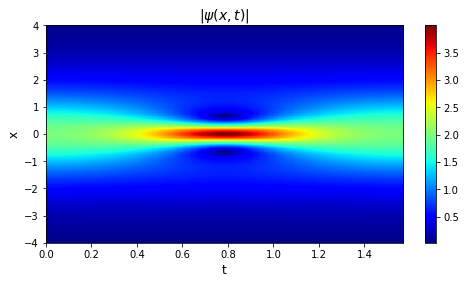

In [ ]:
draw_map(h, [lb[1], ub[1], lb[0], ub[0]],'$ |\psi(x,t)| $')

In [22]:
lb = np.array([x.min(), t.min()])
ub = np.array([x.max(), t.max()])

N0 = 100
N_b = 100
N_f = 20000#15000
layers = [2, 100, 100, 100, 100, 2]

t = t.flatten()[:,None]
x = x.flatten()[:,None]

Exact_u = u.T
Exact_v = v.T
Exact_h = np.sqrt(Exact_u**2 + Exact_v**2)

In [23]:
X, T = np.meshgrid(x,t)
    
X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
u_star = Exact_u.T.flatten()[:,None]
v_star = Exact_v.T.flatten()[:,None]
h_star = Exact_h.T.flatten()[:,None]
    
idx_x = np.random.choice(x.shape[0], N0, replace=False)
x0 = x[idx_x]
u0 = Exact_u[idx_x,0:1]
v0 = Exact_v[idx_x,0:1]
    
idx_t = np.random.choice(t.shape[0], N_b, replace=False)
tb = t[idx_t]
    
#X_f = lb + (ub-lb)*lhs(2, N_f)
lb1 = np.array([-2., 0.])
ub1 = np.array([2., ub[1]])
X_f_1 = lb1 + (ub1 - lb1) * lhs(2, N_f // 2)
X_f_2 = lb + (ub - lb) * lhs(2, N_f // 2)
X_f = np.concatenate((X_f_1, X_f_2), axis=0)

* importance sampling

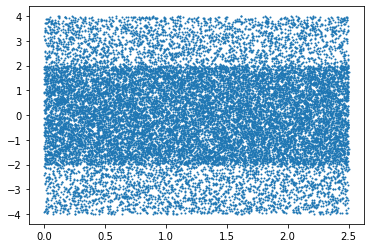

In [ ]:
plt.scatter(X_f[:, 1], X_f[:, 0], s=1)
pass

#### $t_{max} = 1.57$

In [ ]:
model = PhysicsInformedNN(x0, u0, v0, tb, X_f, layers, lb, ub, 0.0)
start_time = time.time()          
model.train()
elapsed = time.time() - start_time
print('Training time: %.4f' % (elapsed))

u, v = model.predict(X_star)

Iter 500, Loss: 7.71404e-02, Loss_u: 4.34491e-02, Loss_f: 3.36913e-02
Iter 1000, Loss: 6.35537e-02, Loss_u: 3.20226e-02, Loss_f: 3.15311e-02
Iter 1500, Loss: 5.64738e-02, Loss_u: 2.75216e-02, Loss_f: 2.89522e-02
Iter 2000, Loss: 5.13851e-02, Loss_u: 2.46987e-02, Loss_f: 2.66864e-02
Iter 2500, Loss: 4.69811e-02, Loss_u: 2.27463e-02, Loss_f: 2.42348e-02
Iter 3000, Loss: 4.26044e-02, Loss_u: 2.04520e-02, Loss_f: 2.21524e-02
Iter 3500, Loss: 3.95824e-02, Loss_u: 1.91279e-02, Loss_f: 2.04545e-02
Iter 4000, Loss: 3.65318e-02, Loss_u: 1.76054e-02, Loss_f: 1.89264e-02
Iter 4500, Loss: 3.38082e-02, Loss_u: 1.63713e-02, Loss_f: 1.74369e-02
Iter 5000, Loss: 3.37100e-02, Loss_u: 1.41769e-02, Loss_f: 1.95331e-02
Iter 5500, Loss: 2.83701e-02, Loss_u: 1.36921e-02, Loss_f: 1.46780e-02
Iter 6000, Loss: 2.61465e-02, Loss_u: 1.26253e-02, Loss_f: 1.35212e-02
Iter 6500, Loss: 2.43390e-02, Loss_u: 1.19386e-02, Loss_f: 1.24004e-02
Iter 7000, Loss: 2.25923e-02, Loss_u: 1.10385e-02, Loss_f: 1.15537e-02
Iter 75

In [ ]:
u = u.flatten()
v = v.flatten()
h = np.sqrt(u**2 + v**2)
u_star = u_star.flatten()
v_star = v_star.flatten()
h_star = h_star.flatten()

In [ ]:
error_u = np.linalg.norm(u_star-u,2)/np.linalg.norm(u_star,2)
error_v = np.linalg.norm(v_star-v,2)/np.linalg.norm(v_star,2)
error_h = np.linalg.norm(h_star-h,2)/np.linalg.norm(h_star,2)
print('Error u: %e' % (error_u))
print('Error v: %e' % (error_v))
print('Error h: %e' % (error_h))

Error u: 1.073535e-02
Error v: 2.892496e-02
Error h: 1.296995e-02


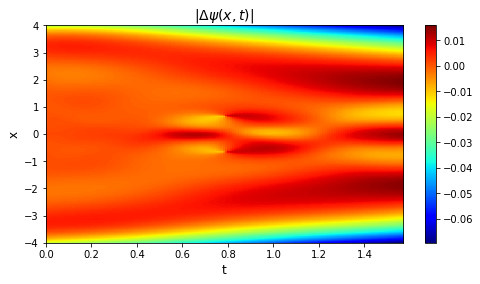

In [ ]:
h_1 = h.reshape((t.shape[0],x.shape[0]))
h_2 = h_star.reshape((t.shape[0],x.shape[0]))
draw_map(h_2 - h_1, [lb[1], ub[1], lb[0], ub[0]], '$ |\Delta \psi(x,t)| $')

#### $t_{max} = 2$

* Data:

In [13]:
#hlf = u.shape[1] // 2
#u = u[:201, hlf - 200: hlf + 201]
#v = v[:201, hlf - 200: hlf + 201]
#x = x[hlf - 200: hlf + 201]
#t = np.linspace(0., 2., 201)
#h = np.sqrt(u**2+v**2)
#lb = np.array([x.min(), t.min()])
#ub = np.array([x.max(), t.max()])
#...

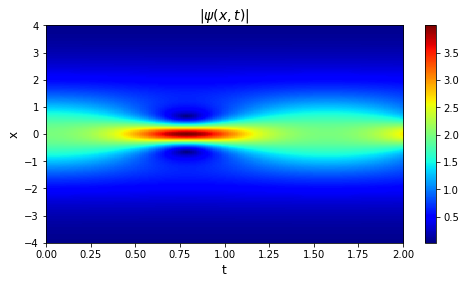

In [15]:
draw_map(h, [lb[1], ub[1], lb[0], ub[0]],'$ |\psi(x,t)| $')

In [ ]:
model = PhysicsInformedNN(x0, u0, v0, tb, X_f, layers, lb, ub, 0.0)
start_time = time.time()          
model.train()
elapsed = time.time() - start_time
print('Training time: %.4f' % (elapsed))

u, v = model.predict(X_star)

Iter 500, Loss: 1.02053e-01, Loss_u: 6.06295e-02, Loss_f: 4.14232e-02
Iter 1000, Loss: 8.13976e-02, Loss_u: 4.16780e-02, Loss_f: 3.97195e-02
Iter 1500, Loss: 6.98239e-02, Loss_u: 3.35356e-02, Loss_f: 3.62884e-02
Iter 2000, Loss: 6.22458e-02, Loss_u: 2.91680e-02, Loss_f: 3.30779e-02
Iter 2500, Loss: 5.59959e-02, Loss_u: 2.57740e-02, Loss_f: 3.02219e-02
Iter 3000, Loss: 5.09587e-02, Loss_u: 2.33652e-02, Loss_f: 2.75935e-02
Iter 3500, Loss: 4.64264e-02, Loss_u: 2.14447e-02, Loss_f: 2.49816e-02
Iter 4000, Loss: 4.31396e-02, Loss_u: 2.00220e-02, Loss_f: 2.31176e-02
Iter 4500, Loss: 3.97861e-02, Loss_u: 1.80712e-02, Loss_f: 2.17149e-02
Iter 5000, Loss: 4.01208e-02, Loss_u: 1.60033e-02, Loss_f: 2.41175e-02
Iter 5500, Loss: 3.42587e-02, Loss_u: 1.56268e-02, Loss_f: 1.86318e-02
Iter 6000, Loss: 3.20451e-02, Loss_u: 1.44443e-02, Loss_f: 1.76008e-02
Iter 6500, Loss: 2.98517e-02, Loss_u: 1.33965e-02, Loss_f: 1.64553e-02
Iter 7000, Loss: 2.77432e-02, Loss_u: 1.23959e-02, Loss_f: 1.53473e-02
Iter 75

In [ ]:
#error

Error u: 2.628862e-02
Error v: 3.404324e-02
Error h: 1.662853e-02


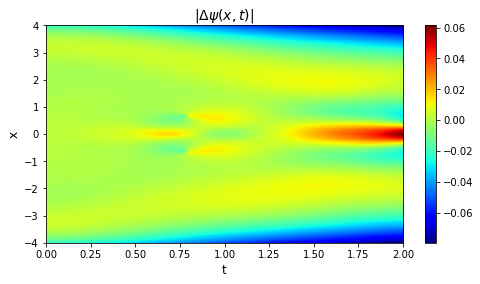

In [ ]:
h_1 = h.reshape((t.shape[0],x.shape[0]))
h_2 = h_star.reshape((t.shape[0],x.shape[0]))
draw_map(h_2 - h_1, [lb[1], ub[1], lb[0], ub[0]], '$ |\Delta \psi(x,t)| $')

#### $ t = 2.5$

* Data:

In [17]:
#hlf = u.shape[1] // 2
#u = u[:, hlf - 200:hlf + 201]
#v = v[:, hlf - 200:hlf + 201]
#x = x[hlf - 200:hlf + 201]

#t = np.linspace(0., 2.5, 251)
#h = np.sqrt(u**2 + v**2)
#lb = np.array([x.min(), t.min()])
#ub = np.array([x.max(), t.max()])

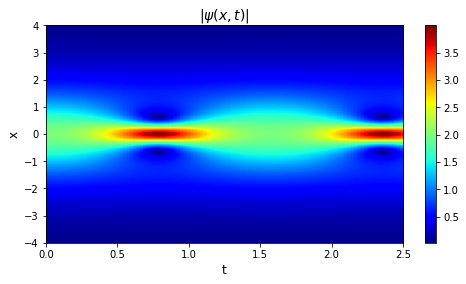

In [18]:
draw_map(h, [lb[1], ub[1], lb[0], ub[0]],'$ |\psi(x,t)| $')

In [ ]:
model = PhysicsInformedNN(x0, u0, v0, tb, X_f, layers, lb, ub, 0.0)
start_time = time.time()          
model.train()
elapsed = time.time() - start_time
print('Training time: %.4f' % (elapsed))

u, v = model.predict(X_star)

Iter 500, Loss: 9.49487e-02, Loss_u: 5.09053e-02, Loss_f: 4.40434e-02
Iter 1000, Loss: 6.86873e-02, Loss_u: 3.02677e-02, Loss_f: 3.84196e-02
Iter 1500, Loss: 5.82219e-02, Loss_u: 2.44537e-02, Loss_f: 3.37682e-02
Iter 2000, Loss: 5.09329e-02, Loss_u: 2.12593e-02, Loss_f: 2.96736e-02
Iter 2500, Loss: 4.50254e-02, Loss_u: 1.89154e-02, Loss_f: 2.61100e-02
Iter 3000, Loss: 3.92650e-02, Loss_u: 1.64289e-02, Loss_f: 2.28360e-02
Iter 3500, Loss: 3.45314e-02, Loss_u: 1.44244e-02, Loss_f: 2.01070e-02
Iter 4000, Loss: 3.07915e-02, Loss_u: 1.27049e-02, Loss_f: 1.80866e-02
Iter 4500, Loss: 2.78422e-02, Loss_u: 1.13371e-02, Loss_f: 1.65052e-02
Iter 5000, Loss: 2.53688e-02, Loss_u: 1.01742e-02, Loss_f: 1.51945e-02
Iter 5500, Loss: 2.32043e-02, Loss_u: 9.17138e-03, Loss_f: 1.40329e-02
Iter 6000, Loss: 2.18511e-02, Loss_u: 8.01387e-03, Loss_f: 1.38373e-02
Iter 6500, Loss: 1.96494e-02, Loss_u: 7.42299e-03, Loss_f: 1.22264e-02
Iter 7000, Loss: 1.84357e-02, Loss_u: 6.93387e-03, Loss_f: 1.15019e-02
Iter 75

In [ ]:
# error

Error u: 3.555808e-01
Error v: 3.408154e-01
Error h: 9.572012e-02


* Error:


  $error(x_i, t_i) = |\Delta \psi'(x_i, t_i)|$



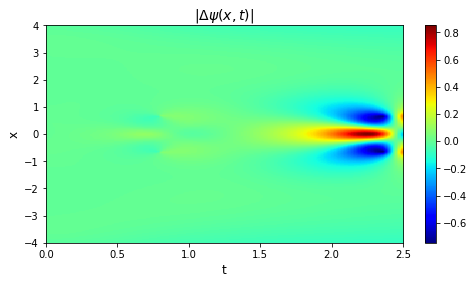

In [ ]:
h_1 = h.reshape((t.shape[0],x.shape[0]))
h_2 = h_star.reshape((t.shape[0],x.shape[0]))
draw_map(h_2 - h_1, [lb[1], ub[1], lb[0], ub[0]], '$ |\Delta \psi(x,t)| $')

In [ ]:
np.savetxt('t_2_5_diff_psi.txt', h_2 - h_1)

## Loss weights

$ L_{PDE} = \sum_i{(1+|\Delta \psi'(x_i, t_i)|) |(i \psi_t + 0.5 \psi_{xx} + |\psi|^2 \psi)|} = \sum_i{error'(x_i, t_i) |f(x_i, t_i)|}$

(modified weights)

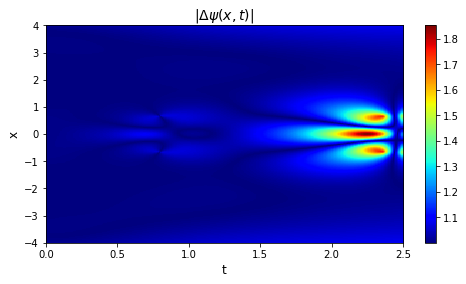

In [20]:
dh = np.loadtxt('t_2_5_diff_psi.txt')
# dh = h_2 - h_1
dh = np.abs(dh)
dh = dh + np.ones_like(dh)
draw_map(dh, [lb[1], ub[1], lb[0], ub[0]], '$ |\Delta \psi(x,t)| $')

In [24]:
dh_x = griddata(X_star, dh.flatten(), X_f, method='cubic')

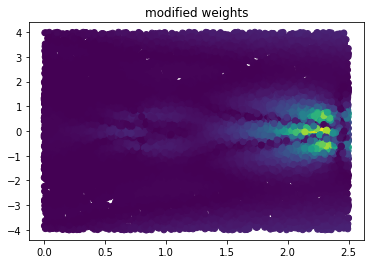

In [26]:
plt.scatter(X_f[:, 1], X_f[:, 0], c=dh_x) 
plt.title('modified weights')
pass

In [ ]:
weights = torch.tensor(dh_x[:, None], requires_grad=False).float().to(device)

In [ ]:
model = PhysicsInformedNN(x0, u0, v0, tb, X_f, layers, lb, ub, 0.0)
start_time = time.time()          
model.train() # 10k adam + importance sampling
elapsed = time.time() - start_time
print('Training time: %.4f' % (elapsed))

u, v = model.predict(X_star)

Iter 500, Loss: 9.65534e-02, Loss_u: 5.69670e-02, Loss_f: 3.95865e-02
Iter 1000, Loss: 7.19998e-02, Loss_u: 3.43043e-02, Loss_f: 3.76955e-02
Iter 1500, Loss: 6.18074e-02, Loss_u: 2.75622e-02, Loss_f: 3.42451e-02
Iter 2000, Loss: 5.49190e-02, Loss_u: 2.43403e-02, Loss_f: 3.05788e-02
Iter 2500, Loss: 4.90304e-02, Loss_u: 2.20544e-02, Loss_f: 2.69760e-02
Iter 3000, Loss: 4.41172e-02, Loss_u: 1.96689e-02, Loss_f: 2.44483e-02
Iter 3500, Loss: 4.00134e-02, Loss_u: 1.78575e-02, Loss_f: 2.21559e-02
Iter 4000, Loss: 3.64419e-02, Loss_u: 1.59492e-02, Loss_f: 2.04927e-02
Iter 4500, Loss: 3.38946e-02, Loss_u: 1.42435e-02, Loss_f: 1.96511e-02
Iter 5000, Loss: 3.00795e-02, Loss_u: 1.30952e-02, Loss_f: 1.69842e-02
Iter 5500, Loss: 2.74684e-02, Loss_u: 1.18133e-02, Loss_f: 1.56551e-02
Iter 6000, Loss: 2.52353e-02, Loss_u: 1.07168e-02, Loss_f: 1.45185e-02
Iter 6500, Loss: 2.29192e-02, Loss_u: 9.56100e-03, Loss_f: 1.33582e-02
Iter 7000, Loss: 2.11015e-02, Loss_u: 8.67097e-03, Loss_f: 1.24306e-02
Iter 75

In [ ]:
error_u = np.linalg.norm(u_star-u,2)/np.linalg.norm(u_star,2)
error_v = np.linalg.norm(v_star-v,2)/np.linalg.norm(v_star,2)
error_h = np.linalg.norm(h_star-h,2)/np.linalg.norm(h_star,2)
print('Error u: %e' % (error_u))
print('Error v: %e' % (error_v))
print('Error h: %e' % (error_h))

Error u: 4.179823e-01
Error v: 4.279549e-01
Error h: 1.156378e-01


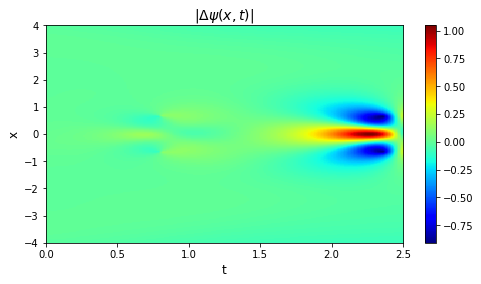

In [ ]:
h_1 = h.reshape((t.shape[0],x.shape[0]))
h_2 = h_star.reshape((t.shape[0],x.shape[0]))
draw_map(h_2 - h_1, [lb[1], ub[1], lb[0], ub[0]], '$ |\Delta \psi(x,t)| $')

* Modified weights + 15k Adam, Nf=20k points

In [ ]:
error_u = np.linalg.norm(u_star-u,2)/np.linalg.norm(u_star,2)
error_v = np.linalg.norm(v_star-v,2)/np.linalg.norm(v_star,2)
error_h = np.linalg.norm(h_star-h,2)/np.linalg.norm(h_star,2)
print('Error u: %e' % (error_u))
print('Error v: %e' % (error_v))
print('Error h: %e' % (error_h))

Error u: 4.840892e-01
Error v: 5.562071e-01
Error h: 1.570728e-01


## Predicted dynamics

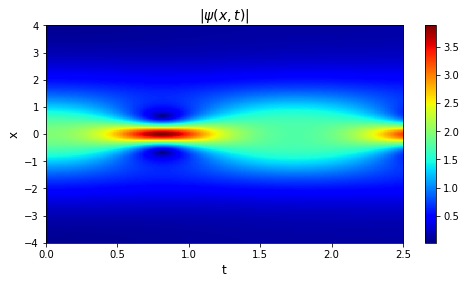

In [ ]:
h_1 = h.reshape((t.shape[0],x.shape[0]))
h_2 = h_star.reshape((t.shape[0],x.shape[0]))
draw_map(h_1, [lb[1], ub[1], lb[0], ub[0]], '$ |\psi(x,t)| $')

* NLSE with dispersion Error


> Error accumulates with time



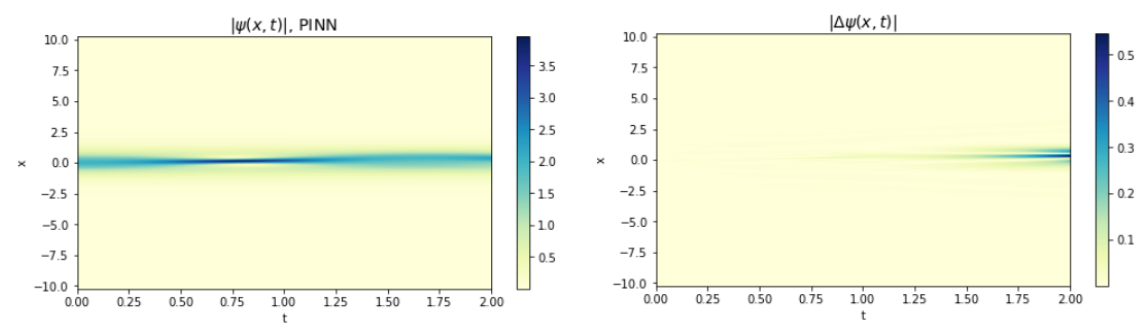